# Preliminaries

In [8]:
import torch
import numpy as np
from numba import jit

In [9]:
import matplotlib.pylab as plt

In [10]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation9b import SampleModel3Jit
from dissipationtheory.dissipation15e import get_device, Cmatrix, twodimCobject
from dissipationtheory.dissipation15e import compute_blds_ac, compute_blds_am
from dissipationtheory.dissipation15e import plotme as plotme15e

In [11]:
THIS = 'dissipation-theory--Study-71--'
figs = {}

# Type III sample computation

Repeat calculations from Study 70 using the GPU-coded functions in `dissipationtheory.dissipation15e`. \
For a Type III sample, compute and plot $\Delta f_{\mathrm{ac}}$, $F_{\mathrm{ac}}$, $\Delta f_{\mathrm{am}}$, and $F_{\mathrm{am}}$ versus modulation frequency $\omega_{\mathrm{m}}$ at selected tip-sample separation $h$.

In [ ]:
device = get_device(verbose=True)

cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sample3 = SampleModel3(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    z_r=ureg.Quantity(1, "nm"),
)

sample3_jit = SampleModel3Jit(**sample3.args())

# 1D torch array of frequencies

omega_m__torch = torch.as_tensor(
    np.logspace(start=3,stop=6,num=40).astype(np.float32), 
    device=device)

omega_am__torch = torch.as_tensor(250.0, device=device)

# 2D torch array of tip displacement vectors

dh__torch = torch.zeros((6, 3), device=device)

dh__torch[:,2] = torch.as_tensor(
    np.linspace(0, 50, 6).astype(np.float32), 
    device=device)

# Numpy arrays of z height and frequency for plotting

h =  100 + dh__torch[:,2].cpu().numpy()
omega_m = omega_m__torch.cpu().numpy() 

# Cantilver at height 100 nm

obj = twodimCobject(sample3, device)
obj.addsphere(ureg.Quantity(100,'nm'), 21, 24)
obj.set_alpha(1.0e-6)
obj.set_integration_points(21 * 15)

In [ ]:
label_df = 'frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]'
label_F = 'force $|F_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [pN]'

Fac, dfac = compute_blds_ac(obj, dh__torch, omega_m__torch)

figs['01a'] = plotme15e(h, omega_m, Fac, label_F, 'voltage modulation: ac')
figs['01b'] = plotme15e(h, omega_m, dfac, label_df, 'voltage modulation: ac')    

In [ ]:
Fam, dfam = compute_blds_am(obj, dh__torch, omega_m__torch, omega_am__torch)

figs['01c'] = plotme15e(h, omega_m, Fam, label_F, 'voltage modulation: ac + am')
figs['01d'] = plotme15e(h, omega_m, dfam, label_df, 'voltage modulation: ac + am')

# Type I sample torch calculation

In [ ]:
from dissipationtheory.dissipation9a import SampleModel1
from dissipationtheory.dissipation9b import SampleModel1Jit
from dissipationtheory.dissipation13e import rpI_jit

## Integrand via compiled CPU code

In [ ]:
sample1 = SampleModel1(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    h_s=ureg.Quantity(500, "nm"),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    epsilon_d=ureg.Quantity(complex(1000, 0), ""),
    z_r=ureg.Quantity(1, "nm")
)

obj = twodimCobject(sample1, device)
obj.addsphere(ureg.Quantity(100,'nm'), 21, 24)
obj.set_alpha(1.0e-6)
obj.set_integration_points(21 * 15)

In [ ]:
y = np.logspace(np.log10(2e-9), np.log10(2.0e1), 100)
omega = 1e5

In [ ]:
zjkref = obj.sj[0,2] +  obj.rk[0,2]
zjkref

In [ ]:
# rpI_jit arguments: y, omega, omega0, zr, kD, hs, es, ed)

# @jit(nopython=True)
def calc_ans_jit(y): 
    ans_jit = np.zeros_like(y, dtype=complex)
    for index, y_ in enumerate(y):

        args_jit = {'y': y_,
            'omega': omega, 
            'omega0': obj.sample.omega0.to('Hz').magnitude,
            'zr': zjkref,
            'kD': obj.sample.kD.to('1/m').magnitude,
            'hs': obj.sample.h_s.to('m').magnitude,
            'es': obj.sample.epsilon_s.to('').magnitude, 
            'ed': obj.sample.epsilon_d.to('').magnitude}

        ans_jit[index] = rpI_jit(**args_jit)
    return ans_jit

In [ ]:
ans_jit = calc_ans_jit(y)

In [ ]:
%timeit calc_ans_jit(y)

In [ ]:
def plot_integrand(y, ans):
    
    fig = plt.figure(figsize=(3.0, 2.5))
    plt.semilogx(y, ans_jit.real, '-', label='Re')
    plt.semilogx(y, ans_jit.imag, '-', label='Im')
    plt.ylabel('$r_p(y)$')
    plt.xlabel('y')
    fig.tight_layout() 
    
    return fig

In [ ]:
figs['02a'] = plot_integrand(y, ans_jit)

## Integrand via compiled GPU code

This function runs faster if it is *not* compiled!

In [ ]:
def rpI(
    y: torch.tensor, 
    omega: float, 
    omega0: float, 
    zr: float, 
    kD: float,
    hs: float,
    es: complex,
    ed: complex
) -> torch.complex128:
    """Fresnel coefficient for Sample III object:

        cantilever | vacuum gap | semiconductor (semi-infinite)

    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega / omega0
    
    theta1 = complex(1,0) * torch.sqrt(
        y**2 * (hs / (zr * 1.0e-9) )**2 + (hs * kD)**2 * (1/es + complex(0,1) * Omega))
    
    theta2 = complex(1,0) * y * hs / (zr * 1.0e-9)

    k_over_eta = y / torch.sqrt(
        y**2 + (zr * 1e-9 * kD) ** 2 * (1 / es + complex(0, 1) * Omega)
    )

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p2 = - Omega**2 / (p0 * p0)
    p3 = complex(0,1) * Omega / (ed * p0)
    p4 = complex(0,1) * Omega * k_over_eta / (es * p0**2) 
    p5 = - k_over_eta**2 / (es**2 * p0**2)
    p6 = complex(0,1) * Omega / p0
    p7 = 1 / ed

    t1 = p1 / torch.tanh(theta1)
    n1 = p2 * torch.tanh(theta1) * torch.tanh(theta2) + p3 * torch.tanh(theta1) + p4
    n2 = - 2 * p4 / (torch.cosh(theta2) * torch.cosh(theta1))
    n3 = p5 * torch.tanh(theta2) / (torch.cosh(theta1) * torch.sinh(theta1))
    # n2 = 0 
    # n3 = 0
    d1 = p6 * torch.tanh(theta1) + torch.tanh(theta2) * (p1 + p7 * torch.tanh(theta1))

    theta_norm = t1 + (n1 + n2 + n3)/d1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

In [ ]:
# rpI arguments: y, omega, omega0, zr, kD, hs, es, ed)

args_torch = {'y': torch.tensor(y),
    'omega': omega, 
    'omega0': obj.sample.omega0.to('Hz').magnitude,
    'zr': zjkref,
    'kD': obj.sample.kD.to('1/m').magnitude,
    'hs': obj.sample.h_s.to('m').magnitude,
    'es': obj.sample.epsilon_s.to('').magnitude, 
    'ed': obj.sample.epsilon_d.to('').magnitude}

In [ ]:
ans_torch = rpI(**args_torch).cpu().numpy()

In [ ]:
%timeit rpI(**args_torch).cpu().numpy()

In [ ]:
figs['02b'] = plot_integrand(y, ans_torch)

## The answers agree

Here we compare the integrand computed over a number of points.

In [ ]:
(ans_jit.size, np.allclose(ans_jit,ans_torch))

## Integrator Try 1

In [ ]:
# rp_III_integrator arguments: omega, omega0, kD, es, sj, rk, dh, pts, device
#   rp_I_integrator arguments: omega, omega0, kD, hs, es, ed, sj, rk, dh, pts, device
#            rpI arguments: y, omega, omega0, zr, kD, hs, es, ed

@torch.compile
def rp_I_integrator(
    omega: float,
    omega0: float,
    kD: float,
    hs: float,
    es: complex,
    ed: complex,
    sj: torch.tensor,
    rk: torch.tensor,
    dh: torch.tensor,
    pts: int,
    device: torch.device,
) -> torch.tensor:

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )

    sj = sj + dh
    rk = rk + dh

    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref

    t0 = torch.exp(w)
    t1 = torch.exp(w - t0)
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpI(t0, omega, omega0, zjkref, kD, hs, es, ed)
    
    I0 = t1 * t2 * t3
    I1 = t0 * I0
    I2 = t0 * I1

    K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
    K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
    K2 = torch.trapezoid(y=I2, x=w) / zjkref**3

    return [K0, K1, K2]  # Works if this is a list but NOT a torch.tensor()

In [ ]:
# rp_I_integrator arguments: omega, omega0, kD, hs, es, ed, sj, rk, dh, pts, device <== 11 arguments
#
#                        rk: None, None, None, None, None, None, None,    0, None, None, None
#                        sj: None, None, None, None, None, None,    0, None, None, None, None 
#                     omega:    0, None, None, None, None, None, None, None, None, None, None 
#                        dh: None, None, None, None, None, None, None, None,    0, None, None 
# 

KmatrixIhw = \
torch.vmap(
    torch.vmap(
        torch.vmap(
            torch.vmap(
                rp_I_integrator,
                in_dims=(None, None, None, None, None, None, None, 0, None, None, None),
                out_dims=0,
            ),
            in_dims=(None, None, None, None, None, None, 0, None, None, None, None),
            out_dims=0,
        ),
        in_dims=(0, None, None, None, None, None, None, None, None, None, None),
        out_dims=0,
    ),
    in_dims=(None, None, None, None, None, None, None, None, 0, None, None),
    out_dims=0
)

In [ ]:
class twodimCobjectExperimental(twodimCobject):
    
    def solve(self, dh_tensor, omega_tensor):
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=self.device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=self.device)
        
        # The Coulomb matrix doesn't depend on tip-sample 
        # separation or frequency

        Ctensor = Cmatrix(sj, rk) 
        
       
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            es = self.sample.epsilon_s.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIIIhw(omega_tensor, omega0, kD, es, sj, rk, dh_tensor, self.pts, self.device)

        elif self.sample.type == 1:
        
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            hs = self.sample.h_s.to('m').magnitude
            es = self.sample.epsilon_s.to('').magnitude            
            ed = self.sample.epsilon_d.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIhw(omega_tensor, omega0, kD, hs, es, ed, sj, rk, dh_tensor, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
                
        C = Ctensor.cpu().numpy()
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        
        return C, K0, K1, K2    

At $h_{\mathrm{s}}$ values greater than about 438 nm, we are getting `nan` values for the $L_n$'s. \
These `nan` values are causing the singular value decomposition step in

    _, dfacI = compute_blds_ac(objI, dh__torch, omega_m__torch)

to fail with the error 

    LinAlgError: SVD did not converge
    
Why is the torch version of `rpI` and `rp_I_integrator` failing like this?

In [ ]:
sampleI = SampleModel1(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    h_s=ureg.Quantity(455, "nm"),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    epsilon_d=ureg.Quantity(complex(1e6, 0), ""),
    z_r=ureg.Quantity(1, "nm")
)

In [ ]:
objI = twodimCobjectExperimental(sampleI, device)
objI.addsphere(ureg.Quantity(100,'nm'), 21, 24)
objI.set_alpha(1.0e-6)
objI.set_integration_points(21 * 15)

In [ ]:
C, L0, L1, L2 = objI.solve(dh__torch, omega_m__torch)

In [ ]:
print(f"Number of NaNs in L0: {np.sum(np.isnan(L0))}")

In [ ]:
(L0.shape, np.argwhere(np.isnan(L0)))

We can see that the higher frequencies are causing trouble.

If I tinker with `rpI` and set

    n2 = 0
    n3 = 0
    
then there are no `nan` values.  \
I suspect the problem comes from the

    1/torch.cosh(theta1) ~ sech(theta1)
    1/torch.sinh(theta1) ~ csch(theta1)
    
terms because `theta1` is getting large `hs` and large `Omega`.

How large an argument can `torch.sinh` and `torch.cosh` handle?

In [ ]:
t0 = torch.tensor([1+0.5j])
t1 = torch.tensor([89, 90])

(torch.sinh(t1), torch.cosh(t1))

Less than about 89, much smaller than the 710.4 limit for `np.cosh` and `np.sinh`. \
Interestingly, torch evaluates `1/inf` to `0` nicely. 

In [ ]:
(1/torch.sinh(t1), 1/torch.cosh(t1))

So why the `nan` values?

In [ ]:
(torch.exp(t1), torch.exp(-t1))

Define my own hyperbolic secant function which involves only $e^{-x}$ and not $e^{x}$.

In [ ]:
def mysech(x):
    
    return 2 * torch.exp(-x)/(1 + torch.exp(- 2 * x))

In [ ]:
(1/torch.cosh(t0), mysech(t0), 1/torch.cosh(t1), mysech(t1))

Define my own hyperbolic cosecant function which involves only $e^{-x}$ and not $e^{x}$.

In [ ]:
def mycsch(x):
    
    return 2 * torch.exp(-x)/(1 - torch.exp(- 2 * x))

In [ ]:
(1/torch.sinh(t0), mycsch(t0), 1/torch.sinh(t1), mycsch(t1))

## Integrator Try 2

In [ ]:
def mysech(x):
    
    return 2 * torch.exp(-x)/(1 + torch.exp(- 2 * x))

In [ ]:
def mycsch(x):
    
    return 2 * torch.exp(-x)/(1 - torch.exp(- 2 * x))

In [ ]:
def rpI(
    y: torch.tensor, 
    omega: float, 
    omega0: float, 
    zr: float, 
    kD: float,
    hs: float,
    es: complex,
    ed: complex
) -> torch.complex128:
    """Fresnel coefficient for Sample III object:

        cantilever | vacuum gap | semiconductor (semi-infinite)

    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega / omega0
    
    theta1 = complex(1,0) * torch.sqrt(
        y**2 * (hs / (zr * 1.0e-9) )**2 + (hs * kD)**2 * (1/es + complex(0,1) * Omega))
    
    theta2 = complex(1,0) * y * hs / (zr * 1.0e-9)

    k_over_eta = y / torch.sqrt(
        y**2 + (zr * 1e-9 * kD) ** 2 * (1 / es + complex(0, 1) * Omega)
    )

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p2 = - Omega**2 / (p0 * p0)
    p3 = complex(0,1) * Omega / (ed * p0)
    p4 = complex(0,1) * Omega * k_over_eta / (es * p0**2) 
    p5 = - k_over_eta**2 / (es**2 * p0**2)
    p6 = complex(0,1) * Omega / p0
    p7 = 1 / ed

    t1 = p1 / torch.tanh(theta1)
    n1 = p2 * torch.tanh(theta1) * torch.tanh(theta2) + p3 * torch.tanh(theta1) + p4
    n2 = - 2 * p4 * mysech(theta2) * mysech(theta1)
    n3 = p5 * torch.tanh(theta2) * mysech(theta1) * mycsch(theta1)
    d1 = p6 * torch.tanh(theta1) + torch.tanh(theta2) * (p1 + p7 * torch.tanh(theta1))

    theta_norm = t1 + (n1 + n2 + n3)/d1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

Code from here below is copied from Try 1.

In [ ]:
# rp_III_integrator arguments: omega, omega0, kD, es, sj, rk, dh, pts, device
#   rp_I_integrator arguments: omega, omega0, kD, hs, es, ed, sj, rk, dh, pts, device
#            rpI arguments: y, omega, omega0, zr, kD, hs, es, ed

@torch.compile
def rp_I_integrator(
    omega: float,
    omega0: float,
    kD: float,
    hs: float,
    es: complex,
    ed: complex,
    sj: torch.tensor,
    rk: torch.tensor,
    dh: torch.tensor,
    pts: int,
    device: torch.device,
) -> torch.tensor:

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )

    sj = sj + dh
    rk = rk + dh

    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref

    t0 = torch.exp(w)
    t1 = torch.exp(w - t0)
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpI(t0, omega, omega0, zjkref, kD, hs, es, ed)
    
    I0 = t1 * t2 * t3
    I1 = t0 * I0
    I2 = t0 * I1

    K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
    K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
    K2 = torch.trapezoid(y=I2, x=w) / zjkref**3

    return [K0, K1, K2]  # Works if this is a list but NOT a torch.tensor()

In [ ]:
# rp_I_integrator arguments: omega, omega0, kD, hs, es, ed, sj, rk, dh, pts, device <== 11 arguments
#
#                        rk: None, None, None, None, None, None, None,    0, None, None, None
#                        sj: None, None, None, None, None, None,    0, None, None, None, None 
#                     omega:    0, None, None, None, None, None, None, None, None, None, None 
#                        dh: None, None, None, None, None, None, None, None,    0, None, None 
# 

KmatrixIhw = \
torch.vmap(
    torch.vmap(
        torch.vmap(
            torch.vmap(
                rp_I_integrator,
                in_dims=(None, None, None, None, None, None, None, 0, None, None, None),
                out_dims=0,
            ),
            in_dims=(None, None, None, None, None, None, 0, None, None, None, None),
            out_dims=0,
        ),
        in_dims=(0, None, None, None, None, None, None, None, None, None, None),
        out_dims=0,
    ),
    in_dims=(None, None, None, None, None, None, None, None, 0, None, None),
    out_dims=0
)

In [ ]:
class twodimCobjectExperimental(twodimCobject):
    
    def solve(self, dh_tensor, omega_tensor):
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=self.device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=self.device)
        
        # The Coulomb matrix doesn't depend on tip-sample 
        # separation or frequency

        Ctensor = Cmatrix(sj, rk) 
        
       
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            es = self.sample.epsilon_s.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIIIhw(omega_tensor, omega0, kD, es, sj, rk, dh_tensor, self.pts, self.device)

        elif self.sample.type == 1:
        
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            hs = self.sample.h_s.to('m').magnitude
            es = self.sample.epsilon_s.to('').magnitude            
            ed = self.sample.epsilon_d.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIhw(omega_tensor, omega0, kD, hs, es, ed, sj, rk, dh_tensor, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
                
        C = Ctensor.cpu().numpy()
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        
        return C, K0, K1, K2

Now test it with $h_{\mathrm{s}} = 4000$ nm, which would have given a $K_0$ matrix full of `nan` entries above.

In [ ]:
sampleI = SampleModel1(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    h_s=ureg.Quantity(4000, "nm"),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    epsilon_d=ureg.Quantity(complex(1e6, 0), ""),
    z_r=ureg.Quantity(1, "nm")
)

objI = twodimCobjectExperimental(sampleI, device)
objI.addsphere(ureg.Quantity(100,'nm'), 21, 24)
objI.set_alpha(1.0e-6)
objI.set_integration_points(21 * 15)

C, L0, L1, L2 = objI.solve(dh__torch, omega_m__torch)

print(f"Number of NaNs in L0: {np.sum(np.isnan(L0))}")

We now see no `nan` entries. \
Success!

In [ ]:
_, dfam = compute_blds_am(objI, dh__torch, omega_m__torch, omega_am__torch)

figs['03a'] = plotme15e(h, omega_m, dfam, label_df, 'voltage modulation: ac + am')

We get nearly the same answer as for the Type III sample, which is expected for a thick Type I sample.

In [ ]:
figs['01d']

Now try a thinner sample, $h_{\mathrm{s}} = 150$ nm.

In [ ]:
sampleI = SampleModel1(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    h_s=ureg.Quantity(150, "nm"),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    epsilon_d=ureg.Quantity(complex(1e6, 0), ""),
    z_r=ureg.Quantity(1, "nm")
)

objI = twodimCobjectExperimental(sampleI, device)
objI.addsphere(ureg.Quantity(100,'nm'), 21, 24)
objI.set_alpha(1.0e-6)
objI.set_integration_points(21 * 15)

_, dfam = compute_blds_am(objI, dh__torch, omega_m__torch, omega_am__torch)

figs['03b'] = plotme15e(h, omega_m, dfam, label_df, 'voltage modulation: ac + am')

Again, for comparison, the Type III sample.

In [ ]:
figs['01d']

Now the Type I and Type III samples exhibit different BLDS spectra. \
The thin Type I sample has less modulation and a broader spectrum. \
Interesting!

# Type I sample torch calculation

I have moved the above code for the Type I sample into `dissipation15e.py`. \
Repeat the above calculation using the code in `dissipation15e.py`. \

If you want, you can run the notebook starting here by restarting the Kernel, running Preliminaries, then running the following code.

In [12]:
import torch
import numpy as np

In [13]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1
from dissipationtheory.dissipation15e import get_device, twodimCobject
from dissipationtheory.dissipation15e import compute_blds_ac, compute_blds_am
from dissipationtheory.dissipation15e import plotme as plotme15e

In [14]:
device = get_device(verbose=True)

cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sampleI = SampleModel1(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    h_s=ureg.Quantity(150, "nm"),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    epsilon_d=ureg.Quantity(complex(1e6, 0), ""),
    z_r=ureg.Quantity(1, "nm")
)

Using MPS (Apple Silicon GPU)


In [15]:
# array of BLDS frequencies and the amplitude-modulation frequency

omega_m__torch = torch.as_tensor(
    np.logspace(start=3,stop=6,num=40).astype(np.float32), 
    device=device)

omega_am__torch = torch.as_tensor(250.0, device=device)

# array of tip-sample separation increments

dh__torch = torch.zeros((6, 3), device=device)
dh__torch[:,2] = torch.as_tensor(
    np.linspace(0, 50, 6).astype(np.float32), 
    device=device)

# array of actual tip-sample separations

h0 = 100 
h =  h0 + dh__torch[:,2].cpu().numpy()
omega_m = omega_m__torch.cpu().numpy() 

In [16]:
label_df = 'frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]'
label_F = 'force $|F_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [pN]'

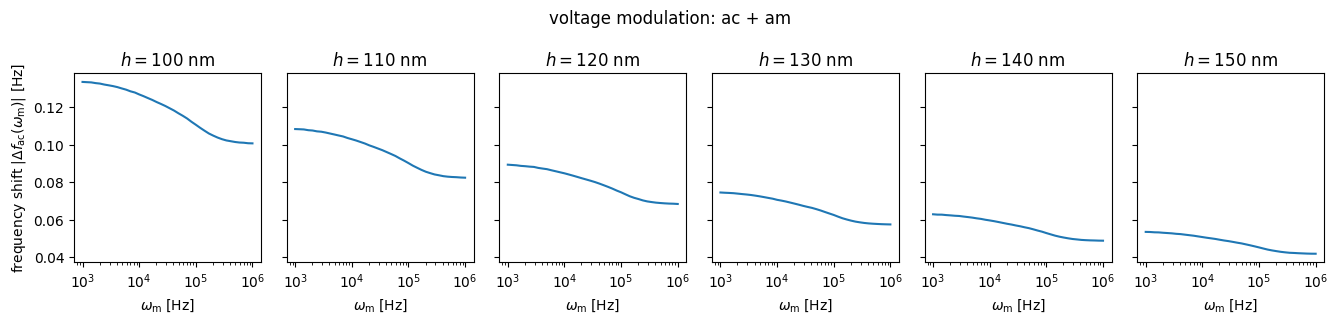

In [17]:
objI = twodimCobject(sampleI, device)
objI.addsphere(ureg.Quantity(h0,'nm'), 21, 24)
objI.set_alpha(1.0e-6)
objI.set_integration_points(21 * 15)

_, dfam = compute_blds_am(objI, dh__torch, omega_m__torch, omega_am__torch)
figs['01'] = plotme15e(h, omega_m, dfam, label_df, 'voltage modulation: ac + am')

# Type I sample torch calculation unit testing

## $K_n$ integrals using Python CPU code

Following Study 64. \
The function `K_jit` uses `integrate.quad_vec` to compute the integrals.

In [18]:
import itertools

from dissipationtheory.dissipation9b import SampleModel1Jit, integrand1jit, K_jit

In [19]:
omegas = 2 * np.pi * np.array(
    [1e1, 1e2, 1e3, 1e4, 1e5, 1e6], dtype=np.float64)

sj_nm = np.array(
    [np.array([  0,  0,  20], dtype=np.float64),
     np.array([  0,  0,  50], dtype=np.float64),
     np.array([  0,  0, 150], dtype=np.float64)])

rk_nm = np.array(
    [np.array([  0,  0, 20], dtype=np.float64),
     np.array([  0, 20, 20], dtype=np.float64),
     np.array([  0,  0, 30], dtype=np.float64),
     np.array([  0, 30, 30], dtype=np.float64)])


epsilon_ss = np.array([complex(  3, 0), complex(  3,  -0.3),
                      complex( 10, 0), complex( 20,  -2.0),
                      complex(100, 0), complex(100, -10.0)])

sigmas = np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2])  # S/m

rhos = np.array([1e19, 1e21, 1e23, 1e25])  # 1/m^3


epsilon_ds = np.array([complex(  3, 0),
                      complex(100, 0)])

h_ss = np.array([20., 100.])

values1 = list(itertools.product(
    omegas, sj_nm, rk_nm,
    epsilon_ss, sigmas, rhos,
    epsilon_ds, h_ss))

len(values1)

34560

In [20]:
values1[0]

(62.83185307179586,
 array([ 0.,  0., 20.]),
 array([ 0.,  0., 20.]),
 (3+0j),
 1e-10,
 1e+19,
 (3+0j),
 20.0)

So we can make a direct comparison, use the same cantilever as in Study 64.

In [21]:
cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

In [22]:
%%time

Kn1 = np.zeros((len(values1),3), dtype=np.complex128)
for index, (omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s) in enumerate(values1):

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample1_jit = SampleModel1Jit(**sample1.args())

    params1 = {
        'integrand': integrand1jit,
        'sample': sample1_jit,
        'omega': omega,
        'location1': 1.0e-9 * sj,
        'location2': 1.0e-9 * rk
    }
    
    K0, K1, K2 = K_jit(**params1)
    Kn1[index] = np.array([K0, K1, K2])

CPU times: user 1min 17s, sys: 350 ms, total: 1min 18s
Wall time: 1min 17s


The matrix `Kn1` contains the complex $K_0$, $K_1$, and $K_2$ integrals computed 34560 values of sample parameters and distances.

In [23]:
Kn1.shape

(34560, 3)

For example,

In [24]:
(values1[0], Kn1[0,:])

((62.83185307179586,
  array([ 0.,  0., 20.]),
  array([ 0.,  0., 20.]),
  (3+0j),
  1e-10,
  1e+19,
  (3+0j),
  20.0),
 array([1.25138524e-02-8.94985007e-06j, 3.12707490e-04-5.60384513e-08j,
        1.56301142e-05-5.31418151e-10j]))

## $K_n$ integrals using GPU code

This takes some thought.

In [25]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation15e import rp_I_integrator

In [26]:
%%time

Kn2 = np.zeros((len(values1),3), dtype=np.complex128)
for index, (omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s) in enumerate(values1):

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))
    
    omega0 = sample1.omega0.to('Hz').magnitude
    kD = sample1.kD.to('1/m').magnitude
    hs = ureg.Quantity(h_s,'nm').to('m').magnitude
    pts = 21 * 15
    
    K0, K1, K2 = rp_I_integrator(
        omega,
        omega0,
        kD,
        hs,
        epsilon_s,
        epsilon_d,
        torch.tensor(sj.astype(np.float32), device=device),
        torch.tensor(rk.astype(np.float32), device=device),
        torch.tensor([0, 0, 0], device=device),
        pts,
        device)
    
    Kn2[index] = np.array([K0.cpu().numpy(), K1.cpu().numpy(), K2.cpu().numpy()])

CPU times: user 26.9 s, sys: 7.6 s, total: 34.5 s
Wall time: 1min 6s


In [27]:
Kn2.shape

(34560, 3)

In [28]:
(values1[0], Kn2[0,:])

((62.83185307179586,
  array([ 0.,  0., 20.]),
  array([ 0.,  0., 20.]),
  (3+0j),
  1e-10,
  1e+19,
  (3+0j),
  20.0),
 array([1.25138517e-02-8.94969526e-06j, 3.12707474e-04-5.60368818e-08j,
        1.56301066e-05-5.31404143e-10j]))

## Compute the relative error in the CPU and GPU integrals

Compute the mean square errors `epsilonR` and `epsilonI`, defined as

\begin{equation}
\epsilon_{\mathrm{r}}^2 =
 \sum_{j = 0}^{2}
 \left(
   \frac{\mathrm{Re}[K_{j}^{\mathrm{CPU}}] - \mathrm{Re}[K_{j}^{\mathrm{GPU}}]}
        {\mathrm{Re}[K_{j}^{\mathrm{CPU}}]}
 \right)^2
\end{equation}

\begin{equation}
\epsilon_{\mathrm{i}}^2 =
 \sum_{j = 0}^{2}
 \left(
   \frac{\mathrm{Im}[K_{j}^{\mathrm{CPU}}] - \mathrm{Im}[K_{j}^{\mathrm{GPU}}]}
        {\mathrm{Im}[K_{j}^{\mathrm{CPU}}]}
 \right)^2
\end{equation}

These errors measure the *relative* difference in the real and imaginary parts of the $K_n$ integrals.

In [29]:
epsilonR = np.zeros((len(values1)), dtype=np.float64)
epsilonI = np.zeros((len(values1)), dtype=np.float64)

for index1, (a,b) in enumerate(zip(Kn1, Kn2)):
    
    cR = np.zeros(3, dtype=np.float64)
    cI = np.zeros(3, dtype=np.float64)
    
    for index2 in [0, 1, 2]:
    
        cR[index2] = (a[index2].real - b[index2].real) / a[index2].real
        cI[index2] = (a[index2].imag - b[index2].imag) / a[index2].imag

    epsilonR[index1] = np.sqrt(cR @ cR)
    epsilonI[index1] = np.sqrt(cI @ cI)

Make a table of the varied parameters and resulting errors $\epsilon_{\mathrm{r}}$ and $\epsilon_{\mathrm{i}}$.

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame(
    values1, 
    columns=['$\omega$ [Hz]', '$s_j$ [nm]', '$r_k$ [nm]', 
             '$\epsilon_{\mathrm{s}}$', '$\sigma$ [S/m]', '$\rho$ [1/m$^3$]',
             '$\epsilon_{\mathrm{d}}$', '$h_{\mathrm{d}}$ [nm]'])
    
df['$\epsilon_{\mathrm{r}}$'] = epsilonR
df['$\epsilon_{\mathrm{i}}$'] = epsilonI

In [32]:
pd.options.display.float_format = '{:,.1e}'.format

Sort by the relative error of the real parts $\epsilon_{\mathrm{r}}$. \
Pleasingly, the largest $\epsilon_{\mathrm{r}}$ is only $7.3 \times 10^{-6}$ or 7.3 parts per million.

In [33]:
df.sort_values(by='$\epsilon_{\mathrm{r}}$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon_{\mathrm{s}}$,$\sigma$ [S/m],$\rho$ [1/m$^3$],$\epsilon_{\mathrm{d}}$,$h_{\mathrm{d}}$ [nm],$\epsilon_{\mathrm{r}}$,$\epsilon_{\mathrm{i}}$
17392,6.3e+04,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",3.0e+00-3.0e-01j,1.0e-06,1.0e+19,3.0e+00+0.0e+00j,2.0e+01,7.3e-06,8.5e-05
5856,6.3e+02,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",3.0e+00-3.0e-01j,1.0e-08,1.0e+19,3.0e+00+0.0e+00j,2.0e+01,7.3e-06,8.5e-05
28928,6.3e+06,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",3.0e+00-3.0e-01j,1.0e-04,1.0e+19,3.0e+00+0.0e+00j,2.0e+01,7.3e-06,8.5e-05
5859,6.3e+02,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",3.0e+00-3.0e-01j,1.0e-08,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,7.3e-06,7.4e-05
28931,6.3e+06,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",3.0e+00-3.0e-01j,1.0e-04,1.0e+19,1.0e+02+0.0e+00j,1.0e+02,7.3e-06,7.4e-05
...,...,...,...,...,...,...,...,...,...,...
16301,6.3e+03,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-04,1.0e+25,3.0e+00+0.0e+00j,1.0e+02,8.8e-09,1.2e-07
4765,6.3e+01,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",1.0e+02-1.0e+01j,1.0e-06,1.0e+25,3.0e+00+0.0e+00j,1.0e+02,8.8e-09,1.2e-07
10331,6.3e+02,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",2.0e+01-2.0e+00j,1.0e-10,1.0e+23,1.0e+02+0.0e+00j,1.0e+02,5.7e-09,2.5e-07
21867,6.3e+04,"[0.0, 0.0, 150.0]","[0.0, 20.0, 20.0]",2.0e+01-2.0e+00j,1.0e-08,1.0e+23,1.0e+02+0.0e+00j,1.0e+02,5.7e-09,2.5e-07


Sort by the relative error of the imaginary parts $\epsilon_{\mathrm{i}}$. \
Disappointingly, the largest $\epsilon_{\mathrm{i}}$ is a horrible $1.1 \times 10^{3}$.

In [34]:
df.sort_values(by='$\epsilon_{\mathrm{i}}$', ascending=False)

,$\omega$ [Hz],$s_j$ [nm],$r_k$ [nm],$\epsilon_{\mathrm{s}}$,$\sigma$ [S/m],$\rho$ [1/m$^3$],$\epsilon_{\mathrm{d}}$,$h_{\mathrm{d}}$ [nm],$\epsilon_{\mathrm{r}}$,$\epsilon_{\mathrm{i}}$
29026,6.3e+06,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+01+0.0e+00j,1.0e-02,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,5.7e-07,1.1e+03
17490,6.3e+04,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+01+0.0e+00j,1.0e-04,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,5.7e-07,1.1e+03
5954,6.3e+02,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+01+0.0e+00j,1.0e-06,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,5.7e-07,1.1e+03
11730,6.3e+03,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+01+0.0e+00j,1.0e-04,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,6.0e-07,1.0e+03
23266,6.3e+05,"[0.0, 0.0, 20.0]","[0.0, 0.0, 20.0]",1.0e+01+0.0e+00j,1.0e-02,1.0e+19,1.0e+02+0.0e+00j,2.0e+01,6.0e-07,1.0e+03
...,...,...,...,...,...,...,...,...,...,...
9285,6.3e+02,"[0.0, 0.0, 50.0]","[0.0, 30.0, 30.0]",1.0e+01+0.0e+00j,1.0e-10,1.0e+21,3.0e+00+0.0e+00j,1.0e+02,3.2e-07,1.4e-08
32357,6.3e+06,"[0.0, 0.0, 50.0]","[0.0, 30.0, 30.0]",1.0e+01+0.0e+00j,1.0e-06,1.0e+21,3.0e+00+0.0e+00j,1.0e+02,3.2e-07,1.4e-08
8507,6.3e+02,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02+0.0e+00j,1.0e-08,1.0e+23,1.0e+02+0.0e+00j,1.0e+02,1.1e-07,1.3e-08
31579,6.3e+06,"[0.0, 0.0, 50.0]","[0.0, 20.0, 20.0]",1.0e+02+0.0e+00j,1.0e-04,1.0e+23,1.0e+02+0.0e+00j,1.0e+02,1.1e-07,1.3e-08


In [35]:
from dissipationtheory.dissipation15e import comparetwoK

The worst $\epsilon_{\mathrm{i}}$ point. \
Observe that the frequency and conductivity are high while the charge density is low.

In [36]:
index = 29026
comparetwoK(Kn1[index], Kn2[index])
values1[index]

Re[K[0]] +2.282302465e-02 vs +2.282302454e-02, relative error = +4.63e-09
Re[K[1]] +5.443985395e-04 vs +5.443984992e-04, relative error = +7.40e-08
Re[K[2]] +2.645984967e-05 vs +2.645983477e-05, relative error = +5.63e-07

Im[K[0]] -2.235332961e-08 vs -2.983711056e-08, relative error = -3.35e-01
Im[K[1]] -6.765715456e-12 vs -2.844101621e-10, relative error = -4.10e+01
Im[K[2]] -1.133630790e-14 vs -1.261936736e-11, relative error = -1.11e+03


(6283185.307179586,
 array([ 0.,  0., 20.]),
 array([ 0.,  0., 20.]),
 (10+0j),
 0.01,
 1e+19,
 (100+0j),
 20.0)

The best $\epsilon_{\mathrm{i}}$ point. \
Observe that the frequency is moderate, the conductivity is low, and the charge density is high.

In [37]:
index = 20043
comparetwoK(Kn1[index], Kn2[index])
values1[index]

Re[K[0]] +1.346434980e-02 vs +1.346435118e-02, relative error = -1.03e-07
Re[K[1]] +1.778338017e-04 vs +1.778338046e-04, relative error = -1.63e-08
Re[K[2]] +4.505820234e-06 vs +4.505820016e-06, relative error = +4.84e-08

Im[K[0]] -3.282780859e-06 vs -3.282780881e-06, relative error = -6.81e-09
Im[K[1]] -5.292555774e-08 vs -5.292555727e-08, relative error = +8.92e-09
Im[K[2]] -1.361056481e-09 vs -1.361056490e-09, relative error = -6.54e-09


(62831.853071795864,
 array([ 0.,  0., 50.]),
 array([ 0., 20., 20.]),
 (100+0j),
 1e-06,
 1e+23,
 (100+0j),
 100.0)

## Plot the errors in various ways

In [38]:
import matplotlib.pylab as plt

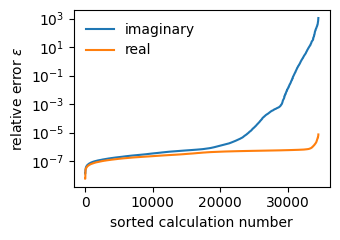

In [40]:
def plotme1(df):

    fig = plt.figure(figsize=(3.5, 2.5))
    plt.semilogy(sorted(df['$\epsilon_{\mathrm{i}}$']), label='imaginary')
    plt.semilogy(sorted(df['$\epsilon_{\mathrm{r}}$']), label='real')
    plt.legend(frameon=False)
    plt.xlabel('sorted calculation number')
    plt.ylabel('relative error $\epsilon$')
    fig.tight_layout()
    
    return fig
    
figs['02'] = plotme1(df)

Cumulative probability.

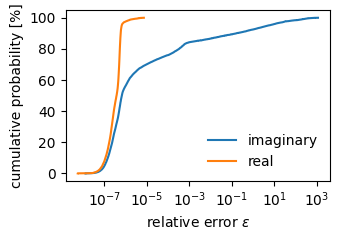

In [41]:
def plotme2(df):

    cp = 100 * np.linspace(0, 1.00, num=len(df))

    fig = plt.figure(figsize=(3.5, 2.5))
    plt.semilogx(sorted(df['$\epsilon_{\mathrm{i}}$']), cp, label='imaginary')
    plt.semilogx(sorted(df['$\epsilon_{\mathrm{r}}$']), cp, label='real')
    plt.legend(frameon=False)
    plt.xlabel('relative error $\epsilon$')
    plt.ylabel('cumulative probability [%]')
    fig.tight_layout()
    
    return fig
    
figs['03'] = plotme2(df)

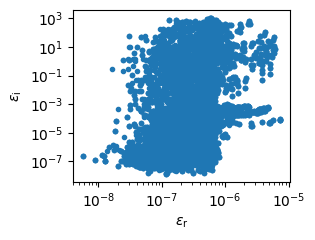

In [42]:
def plotme3(df):

    fig = plt.figure(figsize=(3.25, 2.50))
    plt.loglog(df['$\epsilon_{\mathrm{r}}$'], df['$\epsilon_{\mathrm{i}}$'], '.')
    plt.xlabel('$\epsilon_{\mathrm{r}}$')
    plt.ylabel('$\epsilon_{\mathrm{i}}$')
    fig.tight_layout()
    
    return fig

figs['04'] = plotme3(df)

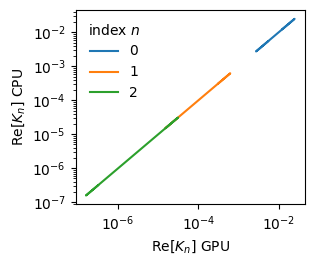

In [43]:
def plotme4(Kn1, Kn2):

    fig = plt.figure(figsize=(3.25, 2.75))
    for index in [0,1,2]:
        plt.loglog(Kn2[:,index].real, 
                   Kn1[:,index].real,
                   label=f'{index:d}')
    plt.legend(frameon=False, title='index $n$')
    plt.xlabel('Re[$K_n$] GPU')
    plt.ylabel('Re[$K_n$] CPU')
    fig.tight_layout()
    
    return fig

figs['05'] = plotme4(Kn1, Kn2)

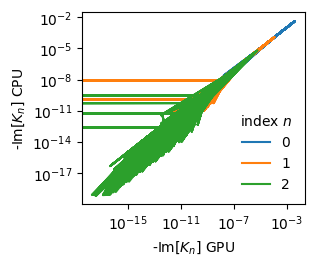

In [44]:
def plotme5(Kn1, Kn2):

    fig = plt.figure(figsize=(3.25, 2.75))
    for index in [0,1,2]:
        plt.loglog(-1 * Kn2[:,index].imag, 
                   -1 * Kn1[:,index].imag,
                   label=f'{index:d}')
    plt.legend(frameon=False, title='index $n$')
    plt.xlabel('-Im[$K_n$] GPU')
    plt.ylabel('-Im[$K_n$] CPU')
    fig.tight_layout()
    
    return fig

figs['06'] = plotme5(Kn1, Kn2)

Sort the real part of the CPU $K_0$ array, and then rearrange the GPU $K_0$ array to be in the same order.?   

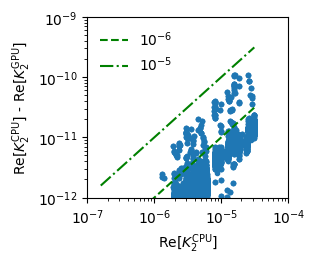

In [45]:
def plotme6(Kn1, Kn2):

    sorted_indices = np.argsort(Kn1[:,2].real)

    fig = plt.figure(figsize=(3.25, 2.75))
    
    x = Kn1[sorted_indices,2].real
    y = (Kn1[sorted_indices,2].real - Kn2[sorted_indices,2].real)
    plt.loglog(x, y, '.')
    plt.loglog(x, 1e-6 * x, 'g--', label='$10^{-6}$')
    plt.loglog(x, 1e-5 * x, 'g-.',label='$10^{-5}$')
    plt.xlim(1e-7,1e-4)
    plt.ylim(1e-12,1e-9)
    plt.xlabel('Re[$K_2^{\mathrm{CPU}}$]')
    plt.ylabel('Re[$K_2^{\mathrm{CPU}}$] - Re[$K_2^{\mathrm{GPU}}$]')
    plt.legend(frameon=False)  
    fig.tight_layout()
    
    return fig

figs['07'] = plotme6(Kn1, Kn2)

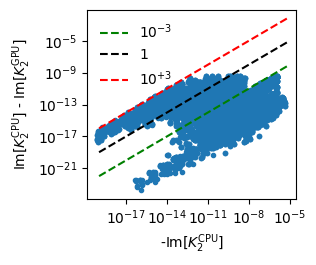

In [46]:
def plotme7(Kn1, Kn2):

    sorted_indices = np.argsort(Kn1[:,2].imag)

    fig = plt.figure(figsize=(3.25, 2.75))
    x = -1 * Kn1[sorted_indices,2].imag
    y = (Kn1[sorted_indices,2].imag - Kn2[sorted_indices,2].imag)
    plt.loglog(x, y, '.')
    plt.loglog(x, 1e-3 * x, 'g--', label='$10^{-3}$')
    plt.loglog(x,        x, 'k--',label='$1$')
    plt.loglog(x, 1e+3 * x, 'r--', label='$10^{+3}$')
    plt.xlabel('-Im[$K_2^{\mathrm{CPU}}$]')
    plt.ylabel('Im[$K_2^{\mathrm{CPU}}$] - Im[$K_2^{\mathrm{GPU}}$]')
    plt.legend(frameon=False)    
    fig.tight_layout()
    
    return fig

figs['08'] = plotme7(Kn1, Kn2)

# Examine the integrand

In [458]:
from dissipationtheory.dissipation9b import integrand1jit, Kp
from dissipationtheory.dissipation15e import rpI

In [459]:
def get_K2integrand_CPU(values1, index):

    omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s = values1[index]

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))

    sample1_jit = SampleModel1Jit(**sample1.args())

    y = np.logspace(np.log10(2e-9), np.log10(2.0e1), 21 * 15)
    K2integrand = np.zeros_like(y, dtype=complex)

    for idx, y_ in enumerate(y):
        _, _, K2integrand[idx] = integrand1jit(y_, sample1_jit, omega, 1.0e-9 * sj, 1.0e-9 * rk) @ Kp
    
    integral = np.trapz(K2integrand, x=y)
    
    return integral, y, K2integrand

In [460]:
def get_K2integrand_GPU(values1, index):
    
    omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s = values1[index]

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))
       
    omega0 = sample1.omega0.to('Hz').magnitude
    kD = sample1.kD.to('1/m').magnitude
    hs = ureg.Quantity(h_s,'nm').to('m').magnitude
    pts = 21 * 15
    
    # start: reproduce rp_I_integrator code

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )    
    
    sj = torch.as_tensor(sj.astype(np.float32), device=device)
    rk = torch.as_tensor(rk.astype(np.float32), device=device)
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref    
    
    t0 = torch.exp(w)
    t1 = torch.exp(w - t0) 
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpI(t0, omega, omega0, zjkref, kD, hs, epsilon_s, epsilon_d)
    
    I0 = t1 * t2 * t3
    
    # I1 = t0 * I0
    # I2 = t0 * I1   
    
    I1 = torch.exp(2 * w - t0) * t2 * t3
    I2 = torch.exp(3 * w - t0) * t2 * t3
        
    # end: reproduce rp_I_integrator code
    
    K2integrand = I2 / zjkref**3
    
    integral = torch.trapezoid(y=K2integrand, x=w).cpu().numpy()
    
    return integral, w.cpu().numpy(), K2integrand.cpu().numpy()

In [461]:
def plotme8(y, K2integrand, xlabel, xscale):

    fig = plt.figure(figsize=(10.0, 2.75))
    plt.plot(y, 1e12 * K2integrand.imag, '.-')
    plt.xlabel(xlabel)
    plt.xscale(xscale)
    plt.ylabel('$K_2$ integrand [$10^{-12}$]')
    fig.tight_layout()
    
    return fig

## Best point

In [462]:
index = 20043

comparetwoK(Kn1[index], Kn2[index])
print() 
print(values1[index])

Re[K[0]] +1.346434980e-02 vs +1.346435118e-02, relative error = -1.03e-07
Re[K[1]] +1.778338017e-04 vs +1.778338046e-04, relative error = -1.63e-08
Re[K[2]] +4.505820234e-06 vs +4.505820016e-06, relative error = +4.84e-08

Im[K[0]] -3.282780859e-06 vs -3.282780881e-06, relative error = -6.81e-09
Im[K[1]] -5.292555774e-08 vs -5.292555727e-08, relative error = +8.92e-09
Im[K[2]] -1.361056481e-09 vs -1.361056490e-09, relative error = -6.54e-09

(62831.853071795864, array([ 0.,  0., 50.]), array([ 0., 20., 20.]), (100+0j), 1e-06, 1e+23, (100+0j), 100.0)


integral = +4.509860e-06 + j * -1.362277e-09


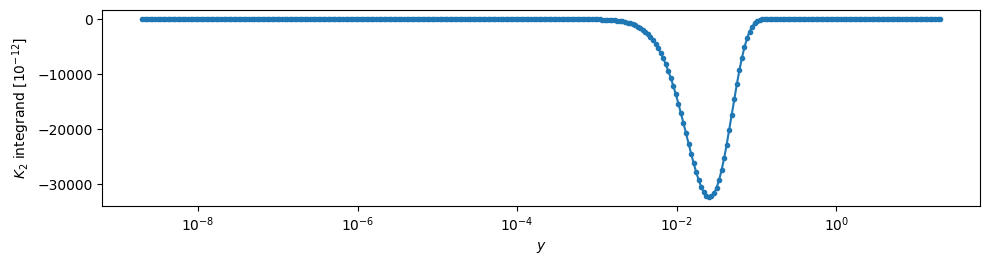

In [463]:
result, y, K2integrand = get_K2integrand_CPU(values1, index)
figs['09a1'] = plotme8(y, K2integrand, xlabel='$y$', xscale='log')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

integral = +4.505820e-06 + j * -1.361056e-09


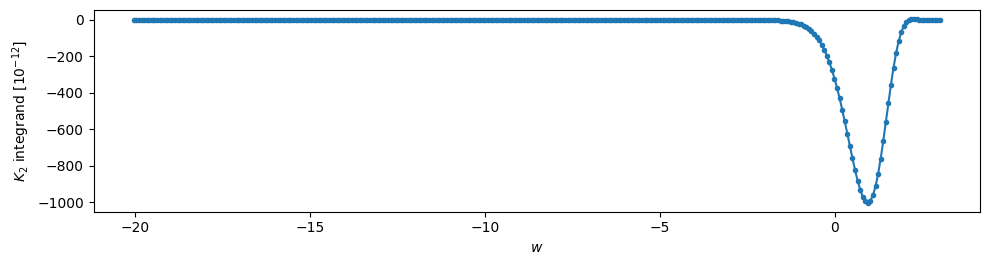

In [464]:
result, w, K2integrand = get_K2integrand_GPU(values1, index)
figs['09a2'] = plotme8(w, K2integrand, xlabel='$w$', xscale='linear')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

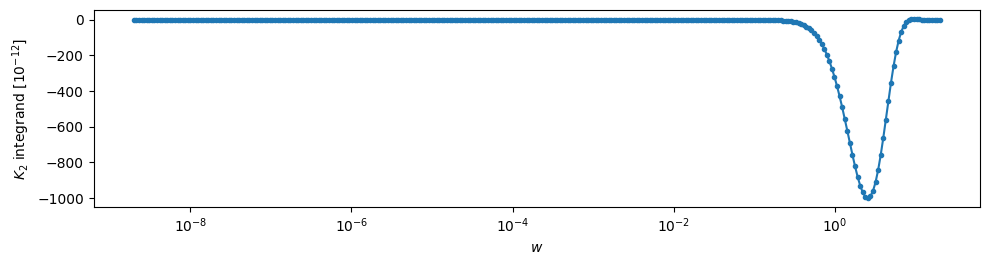

In [465]:
figs['09a3'] = plotme8(np.exp(w), K2integrand, xlabel='$w$', xscale='log')

## Worst point

In [466]:
index = 29026

comparetwoK(Kn1[index], Kn2[index])
print()
print(values1[index])

Re[K[0]] +2.282302465e-02 vs +2.282302454e-02, relative error = +4.63e-09
Re[K[1]] +5.443985395e-04 vs +5.443984992e-04, relative error = +7.40e-08
Re[K[2]] +2.645984967e-05 vs +2.645983477e-05, relative error = +5.63e-07

Im[K[0]] -2.235332961e-08 vs -2.983711056e-08, relative error = -3.35e-01
Im[K[1]] -6.765715456e-12 vs -2.844101621e-10, relative error = -4.10e+01
Im[K[2]] -1.133630790e-14 vs -1.261936736e-11, relative error = -1.11e+03

(6283185.307179586, array([ 0.,  0., 20.]), array([ 0.,  0., 20.]), (10+0j), 0.01, 1e+19, (100+0j), 20.0)


integral = +2.648357e-05 + j * -1.134647e-14


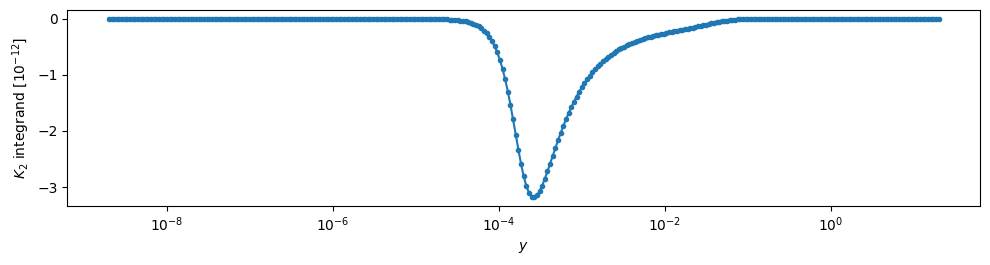

In [467]:
result, y, K2integrand = get_K2integrand_CPU(values1, index)
figs['09b1'] = plotme8(y, K2integrand, xlabel='$y$', xscale='log')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

integral = +2.645983e-05 + j * -1.261936e-11


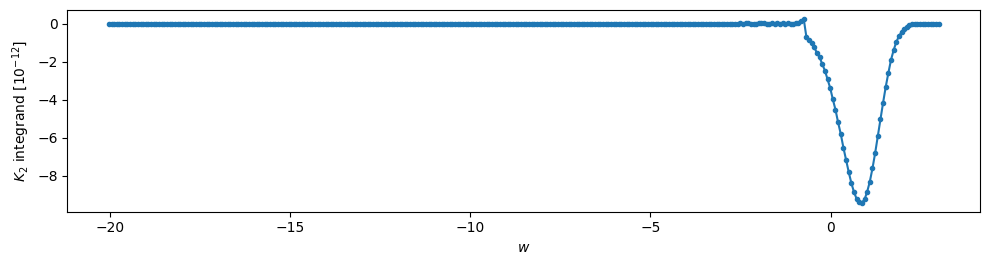

In [468]:
result, w, K2integrand = get_K2integrand_GPU(values1, index)
figs['09b2'] = plotme8(w, K2integrand, xlabel='$w$', xscale='linear')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

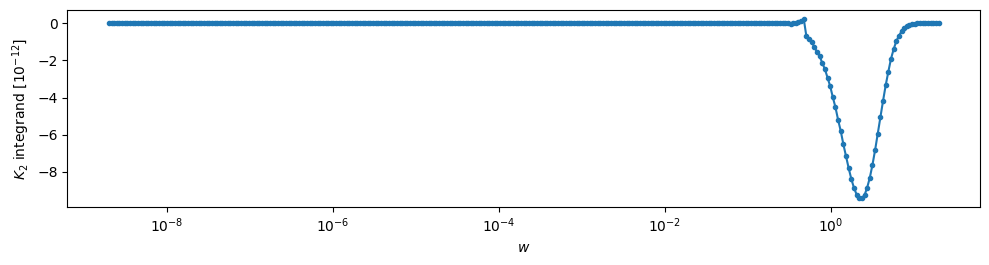

In [469]:
figs['09b3'] = plotme8(np.exp(w), K2integrand, xlabel='$w$', xscale='log')

Why do the integrands disagree?

# Revised GPU function to compute $K_2$

In [471]:
def mysech(x):
    
    # return 2 * torch.exp(-x)/(1 + torch.exp(-2  * x))
    return 1/torch.cosh(x)
    
def mycsch(x):
    
    # return 2 * torch.exp(-x)/(1 - torch.exp(-2 * x))
    return 1/torch.sinh(x)

In [521]:
def rpI(
    y: torch.tensor, 
    omega: float, 
    omega0: float, 
    zr: float, 
    kD: float,
    hs: float,
    es: complex,
    ed: complex
) -> torch.complex128:
    """Fresnel coefficient for Sample III object:

        cantilever | vacuum gap | semiconductor (semi-infinite)

    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega / omega0
    
    theta1 = complex(1,0) * torch.sqrt(y**2 * (hs / zr)**2 + (hs * kD)**2 * (1 / es + complex(0,1) * Omega))
    theta2 = complex(1,0) * y * hs / zr

    k_over_eta = y / torch.sqrt(y**2 + (zr * kD) ** 2 * (1 / es + complex(0, 1) * Omega))

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p2 = - Omega**2 / (p0 * p0)
    p3 = complex(0,1) * Omega / (ed * p0)
    p4 = complex(0,1) * Omega * k_over_eta / (es * p0**2) 
    p5 = - k_over_eta**2 / (es**2 * p0**2)
    p6 = complex(0,1) * Omega / p0
    p7 = 1 / ed

    t1 = p1 / torch.tanh(theta1)
    n1 = p2 * torch.tanh(theta1) * torch.tanh(theta2) + p3 * torch.tanh(theta1) + p4
    n2 = - 2 * p4 * mysech(theta2) * mysech(theta1)
    n3 = p5 * torch.tanh(theta2) * mysech(theta1) * mycsch(theta1)
    d1 = p6 * torch.tanh(theta1) + torch.tanh(theta2) * (p1 + p7 * torch.tanh(theta1))

    theta_norm = t1 + (n1 + n2 + n3)/d1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

In [534]:
def get_K2integrand_GPU_revised(values1, index):
    
    omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s = values1[index]

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))
       
    omega0 = sample1.omega0.to('Hz').magnitude
    kD = sample1.kD.to('1/nm').magnitude
    hs = ureg.Quantity(h_s,'nm').to('nm').magnitude
    pts = 21 * 15
    
    # start: reproduce rp_I_integrator code

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )    
    
    sj = torch.as_tensor(sj.astype(np.float32), device=device)
    rk = torch.as_tensor(rk.astype(np.float32), device=device)
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref    
    
    print('zjkref = ', zjkref)
    print('x = ', x)
     
    t0 = torch.exp(w)    
    t1 = torch.special.bessel_j0(t0 * x)
    t2 = rpI(t0, omega, omega0, zjkref, kD, hs, epsilon_s, epsilon_d)
    
    # end: reproduce rp_I_integrator code    
    
    I0 = torch.exp(1 * w - t0) * t1 * t2  
    I1 = torch.exp(2 * w - t0) * t1 * t2
    I2 = torch.exp(3 * w - t0) * t1 * t2

    K2integrand = I2 / zjkref**3
    
    integral = torch.trapezoid(y=K2integrand, x=w).cpu().numpy()
    
    return integral, w.cpu().numpy(), K2integrand.cpu().numpy()

Best point

Re[K[0]] +1.346434980e-02 vs +1.346435118e-02, relative error = -1.03e-07
Re[K[1]] +1.778338017e-04 vs +1.778338046e-04, relative error = -1.63e-08
Re[K[2]] +4.505820234e-06 vs +4.505820016e-06, relative error = +4.84e-08

Im[K[0]] -3.282780859e-06 vs -3.282780881e-06, relative error = -6.81e-09
Im[K[1]] -5.292555774e-08 vs -5.292555727e-08, relative error = +8.92e-09
Im[K[2]] -1.361056481e-09 vs -1.361056490e-09, relative error = -6.54e-09

(62831.853071795864, array([ 0.,  0., 50.]), array([ 0., 20., 20.]), (100+0j), 1e-06, 1e+23, (100+0j), 100.0)
zjkref =  tensor(70., device='mps:0')
x =  tensor(0.2857, device='mps:0')
integral = +4.505820e-06 + j * -1.361056e-09


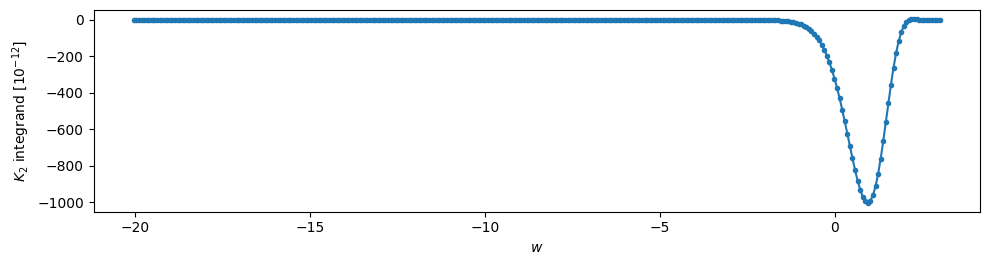

In [536]:
index = 20043

comparetwoK(Kn1[index], Kn2[index])
print()
print(values1[index])

result, w, K2integrand = get_K2integrand_GPU_revised(values1, index)
figs['09c1'] = plotme8(w, K2integrand, xlabel='$w$', xscale='linear')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

Worst point

Re[K[0]] +2.282302465e-02 vs +2.282302454e-02, relative error = +4.63e-09
Re[K[1]] +5.443985395e-04 vs +5.443984992e-04, relative error = +7.40e-08
Re[K[2]] +2.645984967e-05 vs +2.645983477e-05, relative error = +5.63e-07

Im[K[0]] -2.235332961e-08 vs -2.983711056e-08, relative error = -3.35e-01
Im[K[1]] -6.765715456e-12 vs -2.844101621e-10, relative error = -4.10e+01
Im[K[2]] -1.133630790e-14 vs -1.261936736e-11, relative error = -1.11e+03

(6283185.307179586, array([ 0.,  0., 20.]), array([ 0.,  0., 20.]), (10+0j), 0.01, 1e+19, (100+0j), 20.0)
zjkref =  tensor(40., device='mps:0')
x =  tensor(0., device='mps:0')
integral = +2.645983e-05 + j * -1.261882e-11


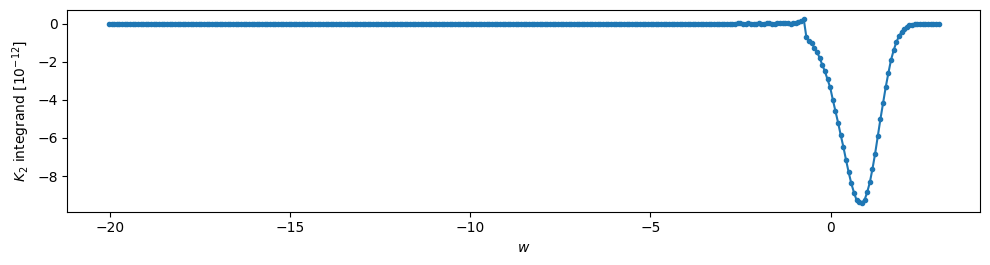

In [537]:
index = 29026

comparetwoK(Kn1[index], Kn2[index])
print()
print(values1[index])

result, w, K2integrand = get_K2integrand_GPU_revised(values1, index)
figs['09c2'] = plotme8(w, K2integrand, xlabel='$w$', xscale='linear')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

# Conclusions

The $r_p$ function is clearly discontinuous in the above plot. 
This pathology suggests that the error in $\mathrm{Im}[K_2]$ at high $\sigma$ and small $\rho$ is a problem with $r_p$ and not with the integration procedure.    There are a couple of possible sources of the faulty $r_p$, keeping in mind that `torch` code on the GPU is running in single precision and $\theta_1$ and $k / \eta$ are complex numbers.  We could have errors in the  

1. the square root of a complex number in $\theta_1$
2. the square root of a complex number in $k / \eta$
3. evaluating `sinh`, `cosh`, or `tanh` with complex argument $\theta_1$. 

In support of Hypotheses 3, see `pytorch` issue 44611 on [github](https://github.com/pytorch/pytorch/issues/44611), "MacOS CPU torch.tan and torch.tanh do not compute some values properly" (and follow the link at the bottom of the issue to [here](https://github.com/numpy/numpy/blob/4b1cd4e118e543260cbe9c7fba51a1de37e03618/numpy/core/src/npymath/npy_math_complex.c.src#L849)).  \
I reproduce the bug below.

In [635]:
(torch.tanh(torch.tensor(-1.5707963267948966j, dtype=torch.cdouble)), np.tanh(-1.5707963267948966j))

(tensor(nan-infj, dtype=torch.complex128), (-0-1.633123935319537e+16j))

This bug concerns CPU, not GPU code, but it is nevertheless concerning. \
Playing around, you can see that `torch.tanh()` and `np.tanh()` can return *very* different values.

In [670]:
np.tanh(np.array([-1.571j])), torch.tanh(torch.tensor([-1.571j]))

(array([-0.+4909.82594232j]), tensor([-0.+6833.4663j]))

Impliment the hyperbolic tangent function for complex argument suggested [here](https://github.com/numpy/numpy/blob/4b1cd4e118e543260cbe9c7fba51a1de37e03618/numpy/core/src/npymath/npy_math_complex.c.src#L849).

In [684]:
def mytanh1(z):
    
    x = z.real
    y = z.imag
    
    t = torch.tan(x)
    beta = 1/(torch.cos(y) ** 2)
    s = torch.sinh(x)
    rho = torch.cosh(x)
    
    return (complex(1,0) * beta * rho * s + complex(0,1) * t)/(1 + beta * s**2) 

In [693]:
np.tanh(2-1j), mytanh1(torch.tensor(2-1j))

((1.0147936161466333-0.03381282607989669j), tensor(1.0148-0.0474j))

This function gives the wrong answer.

Try another implimentation.

In [694]:
def mytanh2(z):
    
    x = z.real
    y = z.imag
    
    return (torch.sinh(2 * x) + complex(0,1) * torch.sin(2 * y))/(torch.cosh(2 * x) + torch.cos(2 * y))

In [695]:
np.tanh(2-1j), mytanh2(torch.tensor(2-1j))

((1.0147936161466333-0.03381282607989669j), tensor(1.0148-0.0338j))

This function does a better job.

Spot check the the `torch` sinh and cosh functions with complex argument.

In [696]:
1/torch.sinh(torch.tensor(-1.571j)), 1/np.sinh(-1.571j)

(tensor(-0.+1.j), (-0+1.0000000207413875j))

In [697]:
1/torch.cosh(torch.tensor(-1.571j)), 1/np.cosh(-1.571j)

(tensor(-4910.3086-0.j), (-4909.826044159563-0j))

The `cosh` fuction is also seems to be having problems.

# Try again to create a revised GPU function for $K_2$

Make my own torch functions for `sech`, `csch`, and `tanh` valid for complex input using notes at the bottom of the page [here](https://en.wikipedia.org/wiki/Hyperbolic_functions#Hyperbolic_functions_for_complex_numbers).

In [784]:
def mysech(z):
    
    x = z.real
    y = z.imag
    
    return 1/(torch.cosh(x) * torch.cos(y) + complex(0,1) * torch.sinh(x) * torch.sin(y))

In [785]:
mysech(torch.tensor(-1.5j)), 1/np.cosh(-1.5j)

(tensor(14.1368+0.j), (14.136832902969903+0j))

In [786]:
def mycsch(z):
    
    x = z.real
    y = z.imag
    
    return 1/(torch.sinh(x) * torch.cos(y) + complex(0,1) * torch.cosh(x) * torch.sin(y))

In [787]:
mycsch(torch.tensor(1-1.5j)), 1/np.sinh(1-1.5j)

(tensor(0.0350+0.6478j), (0.034986175021582806+0.6477921901927566j))

In [788]:
def mytanh(z):
    
    x = z.real
    y = z.imag
    
    return (torch.sinh(2 * x) + complex(0,1) * torch.sin(2 * y))/(torch.cosh(2 * x) + torch.cos(2 * y))

In [789]:
mytanh(torch.tensor(1-1.5j)), np.tanh(1-1.5j)

(tensor(1.3083-0.0509j), (1.3082952992279355-0.05090536232722862j))

In [781]:
def rpIv2(
    y: torch.tensor, 
    omega: float, 
    omega0: float, 
    zr: float, 
    kD: float,
    hs: float,
    es: complex,
    ed: complex
) -> torch.complex128:
    """Fresnel coefficient for Sample III object:

        cantilever | vacuum gap | semiconductor (semi-infinite)

    In the code below, `y` is the unitless integration variable.
    """

    Omega = omega / omega0
    
    theta1 = complex(1,0) * torch.sqrt(y**2 * (hs / zr)**2 + (hs * kD)**2 * (1 / es + complex(0,1) * Omega))
    theta2 = complex(1,0) * y * hs / zr

    k_over_eta = y / torch.sqrt(y**2 + (zr * kD) ** 2 * (1 / es + complex(0, 1) * Omega))

    p0 = 1 + complex(0,1) * es * Omega
    p1 = k_over_eta / (es * p0)
    p2 = - Omega**2 / (p0 * p0)
    p3 = complex(0,1) * Omega / (ed * p0)
    p4 = complex(0,1) * Omega * k_over_eta / (es * p0**2) 
    p5 = - k_over_eta**2 / (es**2 * p0**2)
    p6 = complex(0,1) * Omega / p0
    p7 = 1 / ed

    t1 = p1 / mytanh(theta1)
    n1 = p2 * mytanh(theta1) * mytanh(theta2) + p3 * mytanh(theta1) + p4
    n2 = - 2 * p4 * mysech(theta2) * mysech(theta1)
    n3 = p5 * mytanh(theta2) * mysech(theta1) * mycsch(theta1)
    d1 = p6 * mytanh(theta1) + mytanh(theta2) * (p1 + p7 * mytanh(theta1))

    theta_norm = t1 + (n1 + n2 + n3)/d1
    rp = (1 - theta_norm) / (1 + theta_norm)
 
    return rp

In [782]:
def get_K2integrand_GPU_revised2(values1, index):
    
    omega, sj, rk, epsilon_s, sigma, rho, epsilon_d, h_s = values1[index]

    sample1 = SampleModel1(
        cantilever = cantilever,
        h_s = ureg.Quantity(h_s, 'nm'),
        epsilon_s = ureg.Quantity(epsilon_s, ''),
        epsilon_d = ureg.Quantity(epsilon_d, ''),
        sigma = ureg.Quantity(sigma, 'S/m'),
        rho = ureg.Quantity(rho, '1/m^3'),
        z_r = ureg.Quantity(1, 'nm'))
       
    omega0 = sample1.omega0.to('Hz').magnitude
    kD = sample1.kD.to('1/nm').magnitude
    hs = ureg.Quantity(h_s,'nm').to('nm').magnitude
    pts = 21 * 15
    
    # start: reproduce rp_I_integrator code

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )    
    
    sj = torch.as_tensor(sj.astype(np.float32), device=device)
    rk = torch.as_tensor(rk.astype(np.float32), device=device)
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref    
    
    print('zjkref = ', zjkref)
    print('x = ', x)
     
    t0 = torch.exp(w)    
    t1 = torch.special.bessel_j0(t0 * x)
    t2 = rpIv2(t0, omega, omega0, zjkref, kD, hs, epsilon_s, epsilon_d)
    
    # end: reproduce rp_I_integrator code    
    
    I0 = torch.exp(1 * w - t0) * t1 * t2  
    I1 = torch.exp(2 * w - t0) * t1 * t2
    I2 = torch.exp(3 * w - t0) * t1 * t2

    K2integrand = I2 / zjkref**3
    
    integral = torch.trapezoid(y=K2integrand, x=w).cpu().numpy()
    
    return integral, w.cpu().numpy(), K2integrand.cpu().numpy()

Re[K[0]] +2.282302465e-02 vs +2.282302454e-02, relative error = +4.63e-09
Re[K[1]] +5.443985395e-04 vs +5.443984992e-04, relative error = +7.40e-08
Re[K[2]] +2.645984967e-05 vs +2.645983477e-05, relative error = +5.63e-07

Im[K[0]] -2.235332961e-08 vs -2.983711056e-08, relative error = -3.35e-01
Im[K[1]] -6.765715456e-12 vs -2.844101621e-10, relative error = -4.10e+01
Im[K[2]] -1.133630790e-14 vs -1.261936736e-11, relative error = -1.11e+03

(6283185.307179586, array([ 0.,  0., 20.]), array([ 0.,  0., 20.]), (10+0j), 0.01, 1e+19, (100+0j), 20.0)
zjkref =  tensor(40., device='mps:0')
x =  tensor(0., device='mps:0')
integral = +2.645983e-05 + j * -1.262120e-11


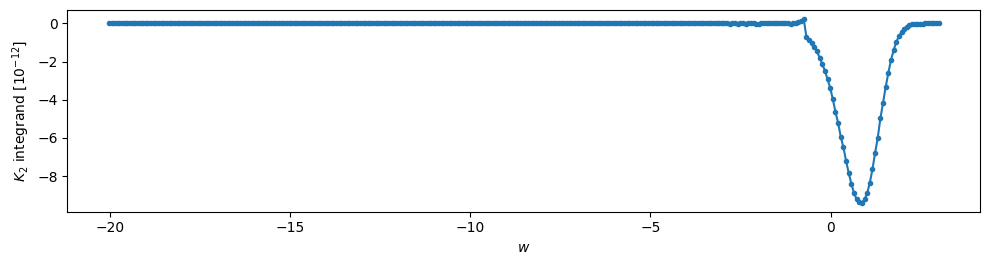

In [790]:
index = 29026

comparetwoK(Kn1[index], Kn2[index])
print()
print(values1[index])

result, w, K2integrand = get_K2integrand_GPU_revised2(values1, index)
figs['10'] = plotme8(w, K2integrand, xlabel='$w$', xscale='linear')

print(f'integral = {result.real:+0.6e} + j * {result.imag:+0.6e}')

The integrand of $K_2$ versus $w$ is still showing a discontinuity. \
Arrgh!!

::: {.content-hidden when-format="html"}

# Save the figures

In [791]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-71.ipynb && open dissipation-theory--Study-71.html
    
:::